###  Questions:

Q1: Identify missing or incorrect data in the dataset and apply appropriate preprocessing steps to clean it (code and explanation)

Q2: What is the average body_mass_g for Gentoo penguins? (code)

Q3: How do the distributions of bill_length_mm and bill_depth_mm differ between the three penguin species? Analyze the skewness and kurtosis of each feature for different species. (code and explanation)

Q4: Identify which features in the dataset have outliers. Provide the method used to detect them and visualize the outliers. (code and explanation)

Q5: Does this dataset contribute to the curse of dimensionality? If yes perform PCA. (code and explanation required)

Q6: Use bill_length_mm vs bill_depth_mm and plot 7 different graphs to visualize them. (code)

Q7: Find the maximum flipper_length_mm for each combination of species and island. Which species has the longest flippers on each island? (code)

Q8: Perform z-score normalization on this dataset. (code)

###

In [512]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [513]:
df = pd.read_csv('./dataset.csv')
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


In [514]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,337.000000,342.000000,342.000000,342.000000
mean,43.876855,17.151170,200.915205,4273.976608
std,5.478600,1.974793,14.061714,1119.229602
min,32.100000,13.100000,172.000000,2700.000000
25%,39.200000,15.600000,190.000000,3550.000000
50%,44.100000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4793.750000
max,59.600000,21.500000,231.000000,15000.000000


In [515]:
df.shape

(344, 7)

In [516]:
df.isna().sum()

species               0
island                0
bill_length_mm        7
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  16
dtype: int64

In [517]:
df['species'].unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

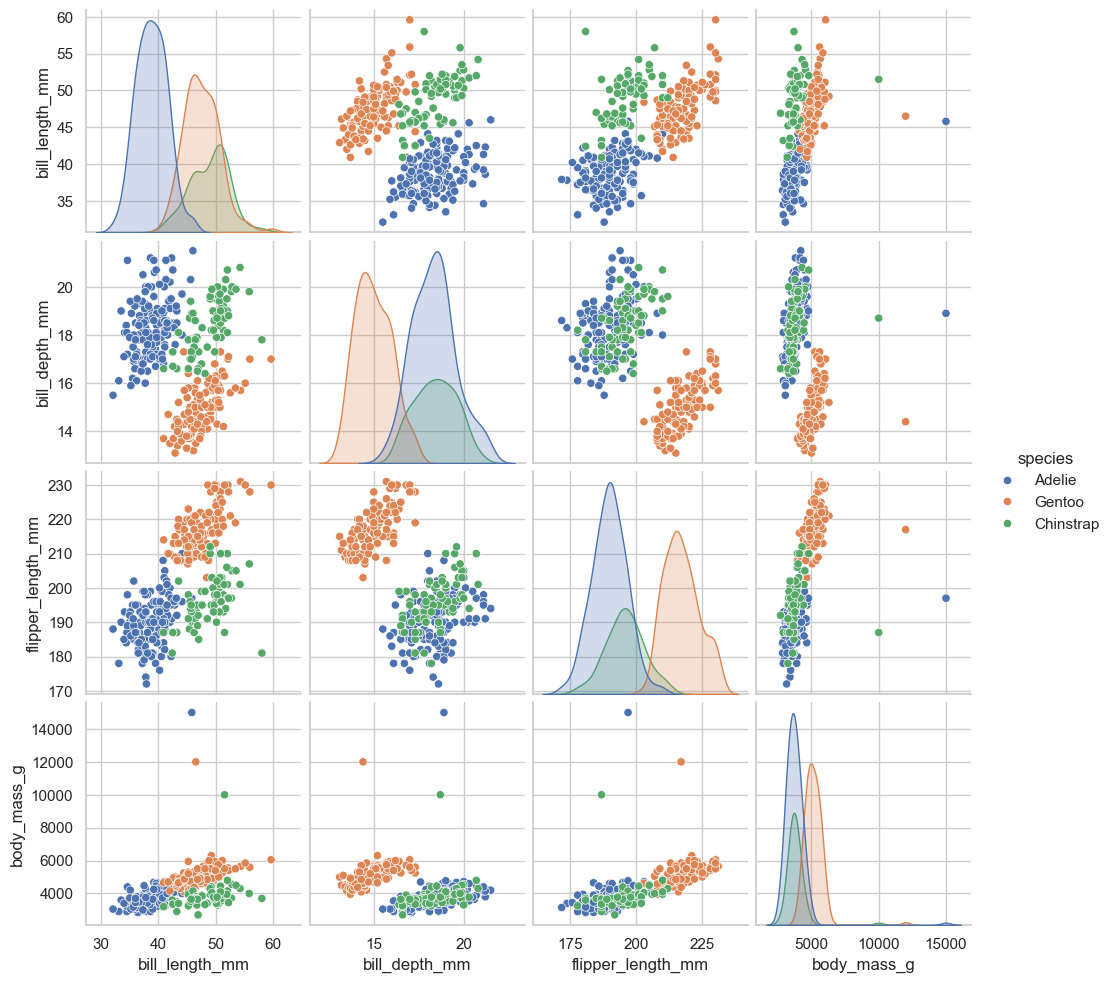

In [518]:
sns.pairplot(df,hue='species')

Question 1 : Identify missing or incorrect data in the dataset and apply appropriate preprocessing steps to clean it (code and explanation)

Explanation : 

In Question 1, we focus on understanding the missing values and how they affect our analysis. We use descriptive statistics and visualizations to get a clear picture of which features have missing values and how much. For instance, if we see that a certain feature has a lot of missing values, we need to decide whether to drop that feature altogether or find a way to fill in those gaps, like using averages or predictions.

here because the 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g' have 2 NaN spots so we can use median of all datapoints from each feature.....why median? because, we plotted the distribution curve and the curve for all these three is skewed...therefore we used median instead of mean. whereas in the first one i.e., 'bill_length_mm' the distribution is normal we could have used mean but there are 7 data points missing....so in this case taking mean as imputation cannot be a good idea therefore first i imputed for all the other 3 parameters using median then i use Regression with the help of most correlated feature for computing missing 'bill_length_mm'.

For the 'sex' column where there are unknown entries are there .....after imputing the other 4 features as mention above i used random forest classifier to find unknown sex entries on the basis of other features.

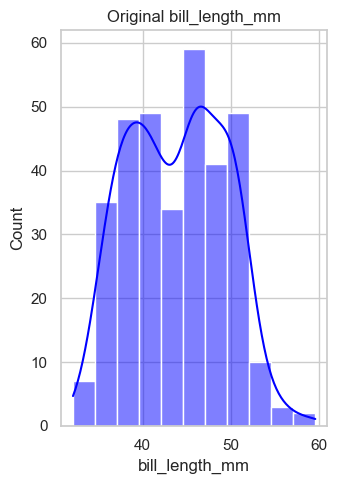

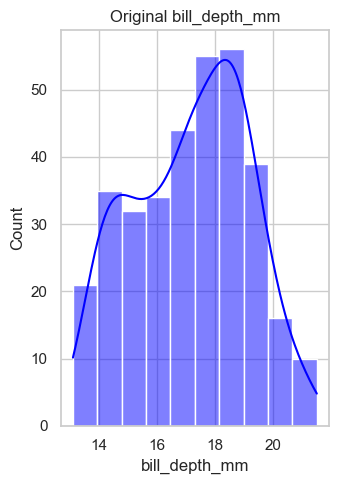

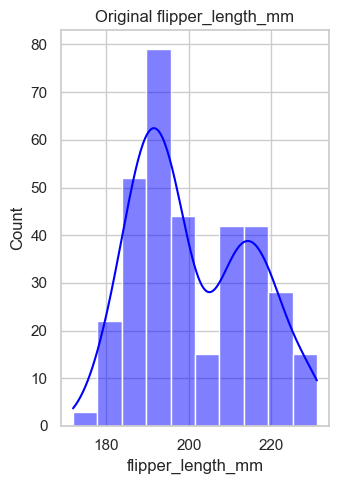

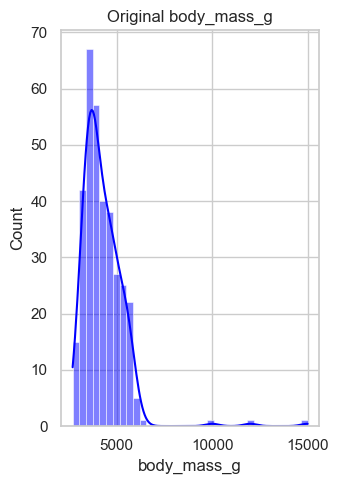

In [519]:
# Features to check imputation methods for
features_to_impute = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Copy of the dataframe with missing values
df_missing = df.copy()

# Drop non-numeric columns for KNN Imputation
df_numeric = df_missing.select_dtypes(include=[np.number])

# Function to plot comparison of different imputation methods
def plot_imputation_comparison(feature):
    plt.figure(figsize=(15, 5))
    
    # Original Data (without NaN)
    plt.subplot(1, 5, 1)
    sns.histplot(df[feature].dropna(), kde=True, color='blue')
    plt.title(f"Original {feature}")
    
    plt.tight_layout()
    plt.show()

# Loop over each feature to check the imputation methods
for feature in features_to_impute:
    plot_imputation_comparison(feature)


In [520]:
# Here we used median as imputation method.
df['bill_depth_mm'] = df['bill_depth_mm'].fillna(df['bill_depth_mm'].median())
df['flipper_length_mm'] = df['flipper_length_mm'].fillna(df['flipper_length_mm'].median())
df['body_mass_g'] = df['body_mass_g'].fillna(df['body_mass_g'].median())

In [521]:
# Check for numeric columns and calculate correlations with bill_length_mm
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[numeric_cols].corr()['bill_length_mm'].sort_values(ascending=False)
print("Correlations with bill_length_mm:")
print(correlations)

most_correlated_feature = correlations.index[1]  
df_no_missing = df.dropna(subset=['bill_length_mm', most_correlated_feature])

# Separate features and target
X = df_no_missing[[most_correlated_feature]]
y = df_no_missing['bill_length_mm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Check for rows where only 'bill_length_mm' is missing but the correlated feature is not
missing_bill_length = df[df['bill_length_mm'].isnull() & df[most_correlated_feature].notnull()]
X_missing = missing_bill_length[[most_correlated_feature]]

# Predict missing bill_length_mm values
if not X_missing.empty:
    predicted_bill_length = regressor.predict(X_missing)

    # Replace missing 'bill_length_mm' values with predicted values
    df.loc[df['bill_length_mm'].isnull() & df[most_correlated_feature].notnull(), 'bill_length_mm'] = predicted_bill_length

# Check the number of remaining missing values in 'bill_length_mm' (should be reduced)
print(f"Remaining missing values in 'bill_length_mm': {df['bill_length_mm'].isnull().sum()}")


Correlations with bill_length_mm:
bill_length_mm       1.000000
flipper_length_mm    0.658861
body_mass_g          0.466729
bill_depth_mm       -0.234154
Name: bill_length_mm, dtype: float64
Remaining missing values in 'bill_length_mm': 0


In [522]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100000,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.500000,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.300000,18.0,195.0,3250.0,female
3,Adelie,Torgersen,42.896991,17.3,197.0,4050.0,NaN
4,Adelie,Torgersen,36.700000,19.3,193.0,3450.0,female
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.800000,19.8,207.0,4000.0,male
340,Chinstrap,Dream,43.500000,18.1,202.0,3400.0,female
341,Chinstrap,Dream,49.600000,18.2,193.0,3775.0,male
342,Chinstrap,Dream,50.800000,19.0,210.0,4100.0,male


In [523]:
# Replace 'unknown' in 'sex' with NaN
df['sex'] = df['sex'].replace('unknown', pd.NA)
df.dropna(subset=['species'], inplace=True)

# Encode categorical variables
le_species = LabelEncoder()
df['encoded_species'] = le_species.fit_transform(df['species'])

le_island = LabelEncoder()
df['encoded_island'] = le_island.fit_transform(df['island'])

# Separate known and unknown sex
known_sex = df[df['sex'].notnull()]
unknown_sex = df[df['sex'].isnull()]

# Features and target variable
# Use encoded columns only
X = known_sex[['encoded_species', 'encoded_island']]  # Include all encoded features you want to use
y = known_sex['sex']

# Split the data for training and testing (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prepare the unknown data for prediction
X_unknown = unknown_sex[['encoded_species', 'encoded_island']]  # Same encoding for unknown data

# Predict the sex for unknown samples
predicted_sex = model.predict(X_unknown)

# Replace unknown values in the original dataframe
df.loc[df['sex'].isnull(), 'sex'] = predicted_sex

# Check the updated DataFrame
print(f'Number of missing values in "sex": {df["sex"].isnull().sum()}')  # Should be 0 now
print(df[['species', 'sex']].head())  # Display some results

# Inverse transform the encoded values back to original species and islands
def inverse_transform(df, encoded_col, label_encoder):
    # Create a new column for the original values
    original_col = f'original_{encoded_col}'
    df[original_col] = label_encoder.inverse_transform(df[encoded_col])
    return df[original_col]

# Apply the inverse transformation for species and islands
df['original_species'] = inverse_transform(df, 'encoded_species', le_species)
df['original_island'] = inverse_transform(df, 'encoded_island', le_island)

# Display the updated DataFrame with original values
print(df[['encoded_species', 'original_species', 'encoded_island', 'original_island', 'sex']].head())



Number of missing values in "sex": 0
  species     sex
0  Adelie    male
1  Adelie  female
2  Adelie  female
3  Adelie  female
4  Adelie  female
   encoded_species original_species  encoded_island original_island     sex
0                0           Adelie               2       Torgersen    male
1                0           Adelie               2       Torgersen  female
2                0           Adelie               2       Torgersen  female
3                0           Adelie               2       Torgersen  female
4                0           Adelie               2       Torgersen  female


In [524]:
print(df.isnull().sum())
df['sex'].unique()
df = df.drop(columns=['original_encoded_species', 'original_species', 'original_encoded_island', 'original_island'], axis = 1)
df

species                     0
island                      0
bill_length_mm              0
bill_depth_mm               0
flipper_length_mm           0
body_mass_g                 0
sex                         0
encoded_species             0
encoded_island              0
original_encoded_species    0
original_species            0
original_encoded_island     0
original_island             0
dtype: int64


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,encoded_species,encoded_island
0,Adelie,Torgersen,39.100000,18.7,181.0,3750.0,male,0,2
1,Adelie,Torgersen,39.500000,17.4,186.0,3800.0,female,0,2
2,Adelie,Torgersen,40.300000,18.0,195.0,3250.0,female,0,2
3,Adelie,Torgersen,42.896991,17.3,197.0,4050.0,female,0,2
4,Adelie,Torgersen,36.700000,19.3,193.0,3450.0,female,0,2
...,...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.800000,19.8,207.0,4000.0,male,1,1
340,Chinstrap,Dream,43.500000,18.1,202.0,3400.0,female,1,1
341,Chinstrap,Dream,49.600000,18.2,193.0,3775.0,male,1,1
342,Chinstrap,Dream,50.800000,19.0,210.0,4100.0,male,1,1


Question 2 : What is the average body_mass_g for Gentoo penguins? (code)

In [525]:
gentoo_penguins = df[df['species'] == 'Gentoo']
average_body_mass = gentoo_penguins['body_mass_g'].mean()
print(f"The average body_mass_g for Gentoo penguins is: {average_body_mass}")

The average body_mass_g for Gentoo penguins is: 5125.0


### Question 3: 
How do the distributions of bill_length_mm and bill_depth_mm differ between the three species? Analyze the skewness and kurtosis of each feature for different species. (code and explanation)




     species  bill_length_mean  bill_length_std  bill_length_skew  \
0     Adelie         38.818401         2.675377          0.150498   
1  Chinstrap         48.714509         3.575022         -0.384553   
2     Gentoo         47.519380         3.080487          0.632547   

   bill_length_kurtosis  bill_depth_mean  bill_depth_std  bill_depth_skew  \
0             -0.229586        18.339474        1.215581         0.329567   
1              0.462836        18.420588        1.135395         0.006726   
2              1.155998        15.000806        0.999146         0.346413   

   bill_depth_kurtosis  
0            -0.096039  
1            -0.898740  
2            -0.584449  


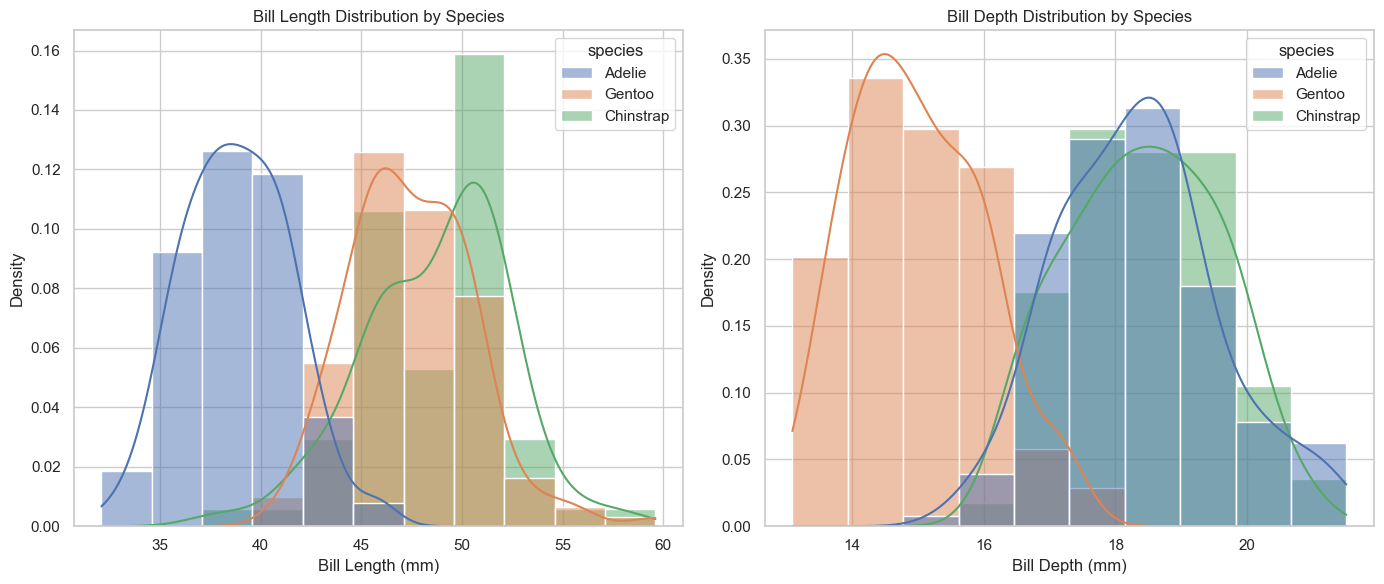

In [526]:
from scipy.stats import skew, kurtosis
# Calculate skewness and kurtosis for each feature by species
stats_summary = df.groupby('species').agg({
    'bill_length_mm': ['mean', 'std', lambda x: skew(x), lambda x: kurtosis(x)],
    'bill_depth_mm': ['mean', 'std', lambda x: skew(x), lambda x: kurtosis(x)]
}).reset_index()

# Rename the columns for better readability
stats_summary.columns = ['species', 
                         'bill_length_mean', 'bill_length_std', 'bill_length_skew', 'bill_length_kurtosis',
                         'bill_depth_mean', 'bill_depth_std', 'bill_depth_skew', 'bill_depth_kurtosis']

print(stats_summary)

# Plot distributions
plt.figure(figsize=(14, 6))

# Bill Length Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='bill_length_mm', hue='species', kde=True, stat="density", common_norm=False)
plt.title('Bill Length Distribution by Species')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Density')

# Bill Depth Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='bill_depth_mm', hue='species', kde=True, stat="density", common_norm=False)
plt.title('Bill Depth Distribution by Species')
plt.xlabel('Bill Depth (mm)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


### Question 3's Explanation : 

To analyze how the distributions of `bill_length_mm` and `bill_depth_mm` differ among the three species, we can start by examining the skewness and kurtosis values for each feature by species.

### Bill Length Analysis

1. **Skewness:**
   - **Adelie**: The skewness is approximately 0.15, indicating that the distribution is fairly symmetrical, with a slight tendency toward longer bills.
   - **Chinstrap**: The skewness is around -0.38, suggesting a slight left skew, meaning more individuals have shorter bill lengths than the average.
   - **Gentoo**: The skewness is about 0.63, which indicates a right-skewed distribution. This suggests that while most Gentoo penguins have shorter bills, there are some with significantly longer bills.

2. **Kurtosis:**
   - **Adelie**: The kurtosis value is -0.23, indicating a distribution that is slightly flatter than a normal distribution. This suggests that there are fewer outliers in bill length.
   - **Chinstrap**: The kurtosis is 0.46, which implies a slightly peaked distribution. This suggests a higher concentration of values near the mean and possibly more outliers.
   - **Gentoo**: The kurtosis is 1.15, indicating a more pronounced peak than a normal distribution, suggesting a greater presence of outliers with longer bill lengths.

### Bill Depth Analysis

1. **Skewness:**
   - **Adelie**: The skewness is around 0.33, indicating a slight right skew, which suggests that most individuals have deeper bills but with some having even deeper bills.
   - **Chinstrap**: The skewness is close to 0.01, suggesting a symmetrical distribution of bill depth.
   - **Gentoo**: The skewness value is about 0.35, which indicates a right skew similar to Adelie, suggesting that most Gentoo penguins have relatively shallow bills, but a few have deeper ones.

2. **Kurtosis:**
   - **Adelie**: The kurtosis value is -0.10, showing a distribution that is flatter than normal, with fewer outliers.
   - **Chinstrap**: The kurtosis is -0.90, indicating a much flatter distribution, suggesting fewer values at the extremes.
   - **Gentoo**: The kurtosis is -0.58, which also suggests a flatter distribution, although less so than Chinstrap.


From this analysis, we can say that the distribution of `bill_length_mm` and `bill_depth_mm` show nice differences among the three penguin species. Adelie penguins tend to have a symmetrical bill length distribution, while Chinstrap has a slight left skew, and Gentoo has a noticeable right skew, indicating variation in longer bills. For bill depth, Adelie and Gentoo exhibit slight right skewness, while Chinstrap's distribution is nearly symmetrical.

In terms of kurtosis, Gentoo's bill length distribution shows a pronounced peak with a greater presence of outliers, while Chinstrap's bill depth distribution is notably flat, indicating a more uniform distribution of bill depths. These characteristics may reflect the different feeding strategies and ecological roles of the species in their respective habitats.



### Question 4: 
Identify which features in the dataset have outliers. Provide the method used to detect them and visualize the outliers. (code and explanation)


Outliers in bill_length_mm:
  Adelie: 0 outliers
  Gentoo: 1 outliers
  Chinstrap: 1 outliers

Outliers in bill_depth_mm:
  Adelie: 1 outliers
  Gentoo: 0 outliers
  Chinstrap: 0 outliers

Outliers in flipper_length_mm:
  Adelie: 2 outliers
  Gentoo: 1 outliers
  Chinstrap: 0 outliers

Outliers in body_mass_g:
  Adelie: 1 outliers
  Gentoo: 1 outliers
  Chinstrap: 3 outliers


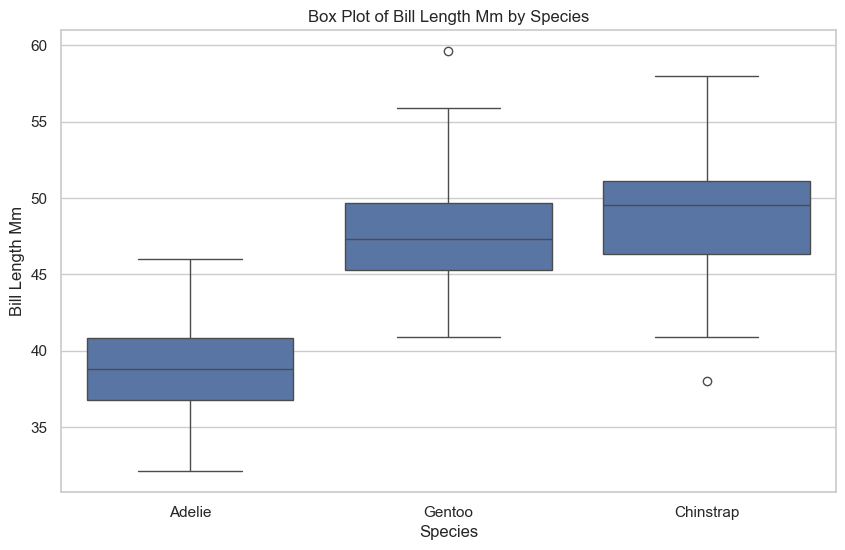

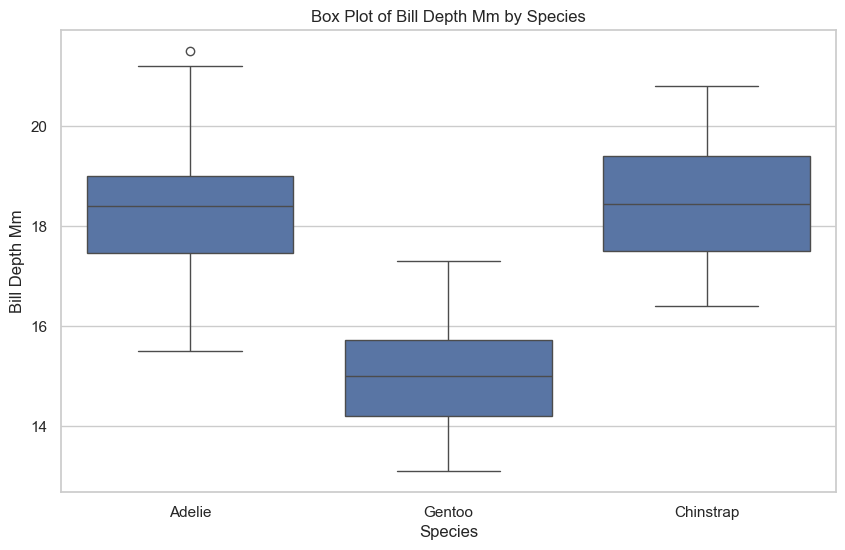

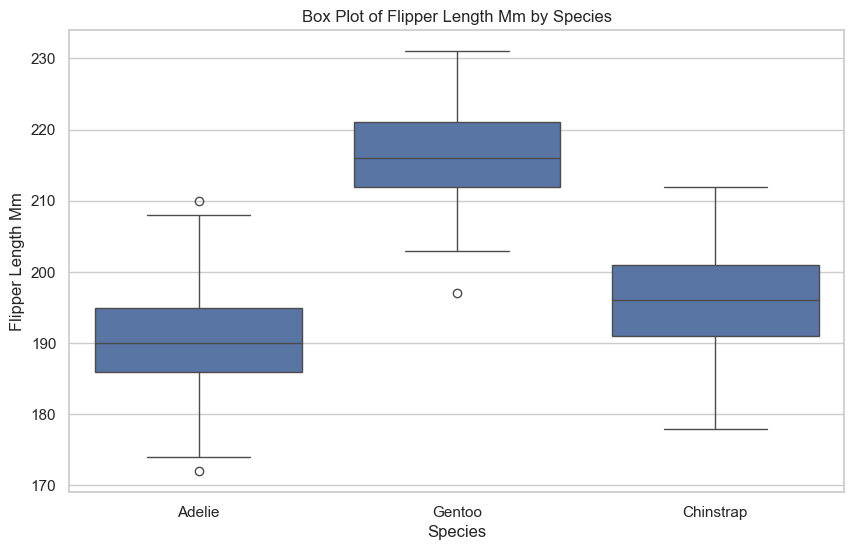

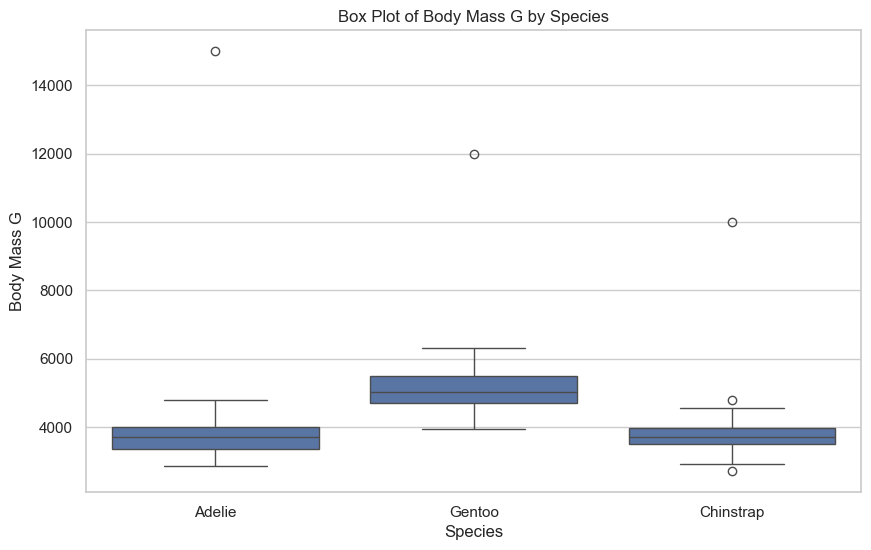

In [527]:
# Function to identify outliers using IQR
def identify_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    
    return outliers

# List of numeric features to check for outliers
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Create a dictionary to store outlier counts for each species and each feature
outlier_counts = {feature: {} for feature in numeric_features}

# Iterate through each feature and species to count outliers
for feature in numeric_features:
    for species in df['species'].unique():
        species_data = df[df['species'] == species]
        outliers = identify_outliers(species_data, feature)
        outlier_counts[feature][species] = outliers.shape[0]

# Print number of outliers for each feature and species
for feature, species_dict in outlier_counts.items():
    print(f"\nOutliers in {feature}:")
    for species, count in species_dict.items():
        print(f'  {species}: {count} outliers')

# Create box plots for each feature by species
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='species', y=feature, data=df)
    plt.title(f'Box Plot of {feature.replace("_", " ").title()} by Species')
    plt.xlabel('Species')
    plt.ylabel(feature.replace('_', ' ').title())
    plt.show()


### Question 4's Explaination
### Outlier Findings

1. **Bill Length (mm):**
   - **Adelie**: 0 outliers
   - **Gentoo**: 1 outlier
   - **Chinstrap**: 1 outlier

   This shows that Adelie penguins have pretty consistent bill lengths, while Gentoo and Chinstrap have a few outliers, meaning there are a few with bill lengths that are much longer or shorter than most.

2. **Bill Depth (mm):**
   - **Adelie**: 1 outlier
   - **Gentoo**: 0 outliers
   - **Chinstrap**: 0 outliers

   Here, only Adelie penguins have one outlier, while Gentoo and Chinstrap have none. This means most bill depths for those species are normal, but there’s at least one Adelie with a deeper bill than usual.

3. **Flipper Length (mm):**
   - **Adelie**: 2 outliers
   - **Gentoo**: 1 outlier
   - **Chinstrap**: 0 outliers

   Adelie and Gentoo have a few outliers, which indicates some penguins have really long or short flippers. Chinstrap don’t show any outliers in this feature.

4. **Body Mass (g):**
   - **Adelie**: 1 outlier
   - **Gentoo**: 1 outlier
   - **Chinstrap**: 3 outliers

   All three species have some outliers here, but Chinstrap has the most. This could mean that they have a wider range of body sizes or maybe some issues with the data for those penguins.

### Box Plots

We also made box plots for each feature by species to visually show the data. These plots help us see where most of the values are, the average, and where the outliers are. Box plots are great for showing how the data spreads out and highlights any extreme values.

### Conclusion

Overall, finding outliers in this dataset helps us understand how different species vary in their physical traits. The presence of outliers can point to differences in how these species adapt or even some mistakes in the data. The box plots give us a clearer picture of these distributions across the species.

### Question 5 : 
Does this dataset contribute to the curse of dimensionality? If yes perform PCA. (code and explanation required)

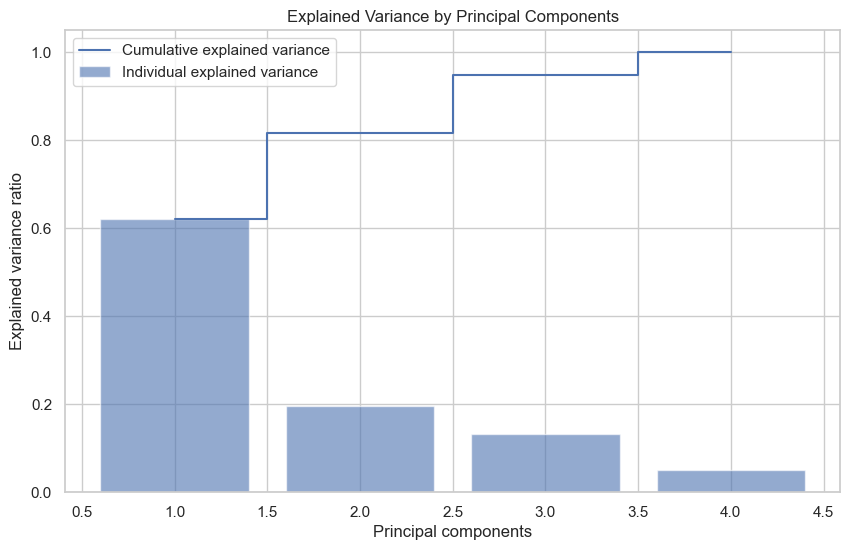

Number of components explaining 80% of variance: 2
        PC1       PC2
0 -1.824940  0.144117
1 -1.280927 -0.367438
2 -1.201946 -0.189229
3 -0.383815 -0.070130
4 -1.795793  0.070779


In [528]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select only numeric columns for PCA
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Drop rows with missing values in the numeric features
df_numeric = df[numeric_features].dropna()

# Step 1: Standardize the numeric features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Step 2: Perform PCA
pca = PCA()
pca_result = pca.fit_transform(df_scaled)

# Step 3: Plot variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()

# Step 4: Print how many components explain 95% of variance
n_components_95 = sum(cumulative_variance <= 0.80)
print(f"Number of components explaining 80% of variance: {n_components_95 + 1}")

# Step 5: If desired, transform the data into reduced components
pca = PCA(n_components=n_components_95 + 1)
df_pca = pca.fit_transform(df_scaled)

# Optional: Convert the reduced data back to a DataFrame
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
print(df_pca.head())


### Question 5's Explanation : 

In this case, PCA was applied to the given dataset to reduce the dimensionality of four numerical features: bill length, bill depth, flipper length, and body mass. The first step involved standardizing these features, which ensures that each one contributes equally to the analysis, as they may have different units and scales. By centering the data, PCA can more effectively identify the directions (principal components) along which the data varies the most.

After standardization, PCA calculated the covariance matrix of the standardized data, revealing how the features relate to each other. It then computed the eigenvalues and eigenvectors of this covariance matrix, where each eigenvalue indicates the amount of variance captured by its corresponding eigenvector (principal component). By sorting the eigenvalues in descending order, you can determine which principal components explain the most variance in the dataset.

When you plotted the explained variance ratio, you could see how much variance each principal component contributed. In your analysis, it was determined that the first two principal components together accounted for 80% of the variance. This means that you can represent the majority of the information contained in the original four features with just these two components, significantly simplifying the dataset. 

By transforming the original data into this reduced set of principal components, you now have a more manageable dataset that retains most of the meaningful information, making it easier for further analysis or visualization while minimizing the complexity that comes from the original multiple features. This approach is particularly useful for understanding patterns and relationships within the data without being overwhelmed by its dimensionality.

### Question 6 :  
Use bill_length_mm vs bill_depth_mm and plot 7 different graphs to visualize them. (code)

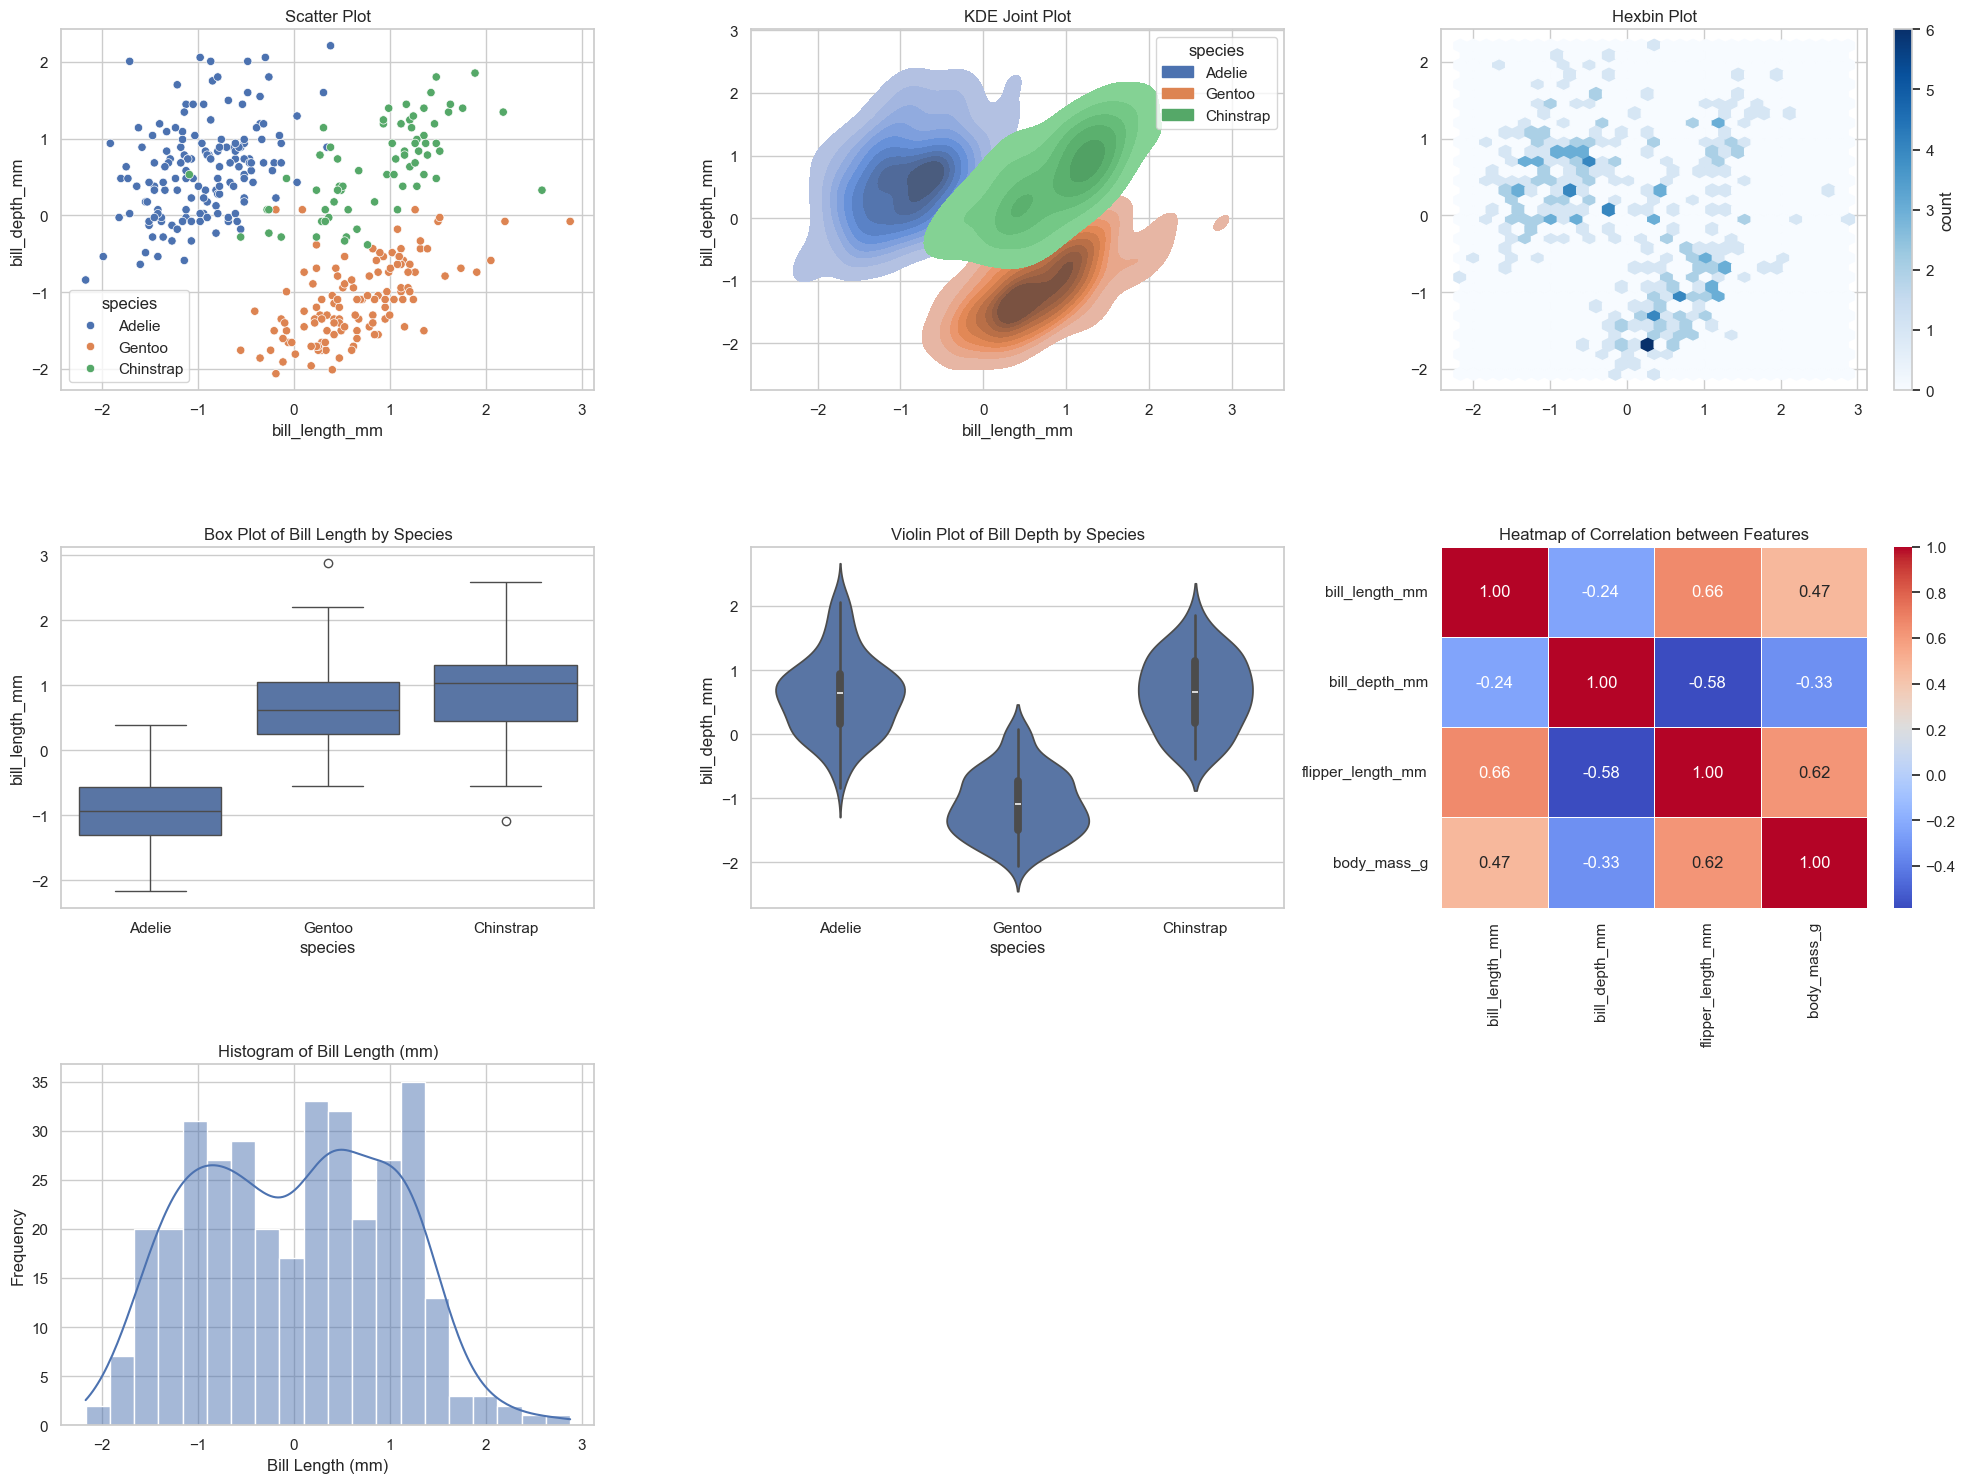

In [532]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Set the style for seaborn
sns.set(style="whitegrid")

# Initialize figure
plt.figure(figsize=(20, 15))

# 1. Scatter Plot
plt.subplot(3, 3, 1)
sns.scatterplot(x='bill_length_mm', y='bill_depth_mm', hue='species', data=df)
plt.title('Scatter Plot')
plt.savefig('scatter_plot.png')  # Save the scatter plot

# 2. Joint Plot (Density)
plt.subplot(3, 3, 2)
sns.kdeplot(x='bill_length_mm', y='bill_depth_mm', hue='species', data=df, fill=True)
plt.title('KDE Joint Plot')
plt.savefig('kde_joint_plot.png')  # Save the KDE plot

# 3. Hexbin Plot (using Matplotlib)
plt.subplot(3, 3, 3)
plt.hexbin(df['bill_length_mm'], df['bill_depth_mm'], gridsize=30, cmap='Blues')
plt.colorbar(label='count')
plt.title('Hexbin Plot')
plt.savefig('hexbin_plot.png')  # Save the hexbin plot

# 4. Box Plot
plt.subplot(3, 3, 4)
sns.boxplot(x='species', y='bill_length_mm', data=df)
plt.title('Box Plot of Bill Length by Species')
plt.savefig('box_plot_bill_length.png')  # Save the box plot

# 5. Violin Plot
plt.subplot(3, 3, 5)
sns.violinplot(x='species', y='bill_depth_mm', data=df)
plt.title('Violin Plot of Bill Depth by Species')
plt.savefig('violin_plot_bill_depth.png')  # Save the violin plot

# 6. Pair Plot (Using a separate figure since pairplot cannot be placed in subplots)
sns.pairplot(df, hue='species', vars=['bill_length_mm', 'bill_depth_mm'])
plt.savefig('pair_plot.png')  # Save the pair plot
plt.close()  # Close the figure to avoid display

# 7. Heatmap of Correlation
plt.subplot(3, 3, 6)
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation between Features')
plt.savefig('heatmap_correlation.png')  # Save the heatmap plot

# 8. Histogram of Bill Length
plt.subplot(3, 3, 7)
sns.histplot(df['bill_length_mm'], bins=20, kde=True)
plt.title('Histogram of Bill Length (mm)')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Frequency')
plt.savefig('histogram_bill_length.png')  # Save the histogram plot

# Adjust layout and show the static plots
plt.tight_layout()
plt.show()


Q7: Find the maximum flipper_length_mm for each combination of species and island. Which species has the longest flippers on each island? (code)

In [530]:
# Grouping by species and island to find the maximum flipper_length_mm
max_flipper_lengths = df.groupby(['species', 'island'])['flipper_length_mm'].max().reset_index()

# Print the maximum flipper length for each species and island
print("Maximum flipper_length_mm for each species and island combination:")
print(max_flipper_lengths)

# Finding which species has the longest flippers on each island
longest_flippers_per_island = df.loc[df.groupby(['island'])['flipper_length_mm'].idxmax()][['island', 'species', 'flipper_length_mm']]

print("\nSpecies with the longest flippers on each island:")
print(longest_flippers_per_island)


Maximum flipper_length_mm for each species and island combination:
     species     island  flipper_length_mm
0     Adelie     Biscoe              203.0
1     Adelie      Dream              208.0
2     Adelie  Torgersen              210.0
3  Chinstrap      Dream              212.0
4     Gentoo     Biscoe              231.0

Species with the longest flippers on each island:
        island    species  flipper_length_mm
215     Biscoe     Gentoo              231.0
323      Dream  Chinstrap              212.0
129  Torgersen     Adelie              210.0


Question 8 : Perform z-score normalization on this dataset. (code)


In [531]:
# from sklearn.preprocessing import StandardScaler

# Selecting numerical features for Z-score normalization
numerical_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

# Initialize the StandardScaler
scaler = StandardScaler()

# Perform Z-score normalization on the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows of the normalized data
print("Z-score normalized data:")
print(df.head())


Z-score normalized data:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen       -0.882225       0.787289          -1.420541   
1  Adelie  Torgersen       -0.808875       0.126114          -1.063485   
2  Adelie  Torgersen       -0.662174       0.431272          -0.420786   
3  Adelie  Torgersen       -0.185947       0.075255          -0.277964   
4  Adelie  Torgersen       -1.322328       1.092447          -0.563608   

   body_mass_g     sex  encoded_species  encoded_island  
0    -0.468990    male                0               2  
1    -0.424125  female                0               2  
2    -0.917634  female                0               2  
3    -0.199803  female                0               2  
4    -0.738176  female                0               2  
